In [94]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
import math as m
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [4]:
sigma_z_prior = 1
pi = np.pi

függvény adatgeneráláshoz (csak a posteriorhoz szükséges dolgokat adja):

In [142]:
def generate_data(is_simple, N, alpha, sigma_reward):
  if is_simple:
    z_ = tfd.Sample(
      tfd.Independent(
          tfd.Normal(loc=[0, 0], scale=[sigma_z_prior, sigma_z_prior])))
    z = z_.sample(N)

    gamma_0 = 1
    r = np.zeros(N)
    for i in range(N):
      r_ = tfd.Sample(
        tfd.Independent(
            tfd.Normal(loc=gamma_0*z[i, 0], scale=sigma_reward)))
      r[i] = r_.sample(1)
  else:
      z_ = tfd.Sample(
      tfd.Independent(
          tfd.Normal(loc=[0, 0], scale=[sigma_z_prior, sigma_z_prior])))
      z = z_.sample(N)
    
      gamma_0 = np.array([np.cos(alpha), np.sin(alpha)])
      r = np.zeros(N)
      for i in range(N):
        r_ = tfd.Sample(
          tfd.Independent(
              tfd.Normal(loc = gamma_0[0]*z[i, 0] + gamma_0[1]*z[i, 1], scale=sigma_reward)))
        r[i] = r_.sample(1)

  cov_inverses = np.zeros((N, 2, 2))
  mus = np.zeros((N, 2))
  for i in range(N):
    z_aux = np.expand_dims(z[i], -1) # oszlop
    z_aux_T = np.transpose(z_aux) # sor
    cov_inverses[i, :, :] = 1/sigma_reward**2*np.matmul(z_aux, z_aux_T)
    cov = np.linalg.inv(cov_inverses[i])
    mus[i] = np.squeeze(np.transpose(r[i]*np.matmul(cov, z_aux))/sigma_reward**2)
  return mus, cov_inverses

ilyen paraméterekkel fogok majd adatot generálni (is_simple=False csak annyit tesz, hogy nem axis-aligned a decision boundary):

In [151]:
is_simple = False
alpha = 20/180*pi
sigma_reward = .1

segédfüggvények, melyek két tényezős Gauss-szorzatok paramétereit köpik ki:

In [76]:
def cov_inverse_of_product(cov_inv1, cov_inv2):
  return cov_inv1 + cov_inv2

def mu_of_product(cov_inv1, cov_inv2, mu1, mu2):
  return np.matmul(np.linalg.inv(cov_inv1 + cov_inv2), (np.matmul(cov_inv1, mu1) + np.matmul(cov_inv2, mu2)))

generálunk több különböző méretű adathalmazt, majd végigiterálunk a generált adatokon és iteratívan kiszámoljuk mut és cov_inverset:


In [160]:
Ns = [1, 50, 100, 1000]
n = len(Ns)
mu_vects = np.zeros((n, 2))
cov_matrices = np.zeros((n, 2, 2))
for idx, N in enumerate(Ns):
  mus, cov_inverses = generate_data(is_simple, N, alpha, sigma_reward)
  mu = np.zeros((2, 1))
  cov_inverse = np.array([[1, 0], [0, 1]])
  for i in range(N):
    mu_ = np.expand_dims(mus[i], -1) #oszlop
    mu = mu_of_product(cov_inverse, cov_inverses[i], mu, mu_)
    cov_inverse = cov_inverse_of_product(cov_inverse, cov_inverses[i])
  cov = np.linalg.inv(cov_inverse)
  mu_vects[idx] = np.transpose(mu)
  cov_matrices[idx] = cov
  print(N)

1
50
100
1000


In [161]:
mu_vects

array([[ 0.74148928, -0.13166956],
       [ 0.92915511,  0.36375861],
       [ 0.92535055,  0.33562456],
       [ 0.94104745,  0.34220476]])

In [101]:
print('ground truth gamma: (%f, %f)'%(np.cos(alpha), np.sin(alpha)))

ground truth gamma: (0.939693, 0.342020)


In [147]:
nn = 1000
X = np.linspace(-2, 2, nn)
Y = np.linspace(-2, 2, nn)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)

    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / nn



In [146]:
def plot_gaussian(Mu, Sigma):  
  Z = multivariate_gaussian(pos, Mu, Sigma)


  fig = plt.figure(figsize=(20, 15))
  ax1 = fig.add_subplot(2,1,1,projection='3d')

  ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                  cmap=cm.viridis)
  ax1.view_init(55,-70)

  ax1.set_xlabel(r'$gamma_1$')
  ax1.set_ylabel(r'$gamma_2$')

  ax2 = fig.add_subplot(2,1,2,projection='3d')
  ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
  ax2.view_init(90, 270)

  ax2.grid(False)

  ax2.set_xlabel(r'$gamma_1$')
  ax2.set_ylabel(r'$gamma_2$')

  plt.show()

1 adatpont esetén:

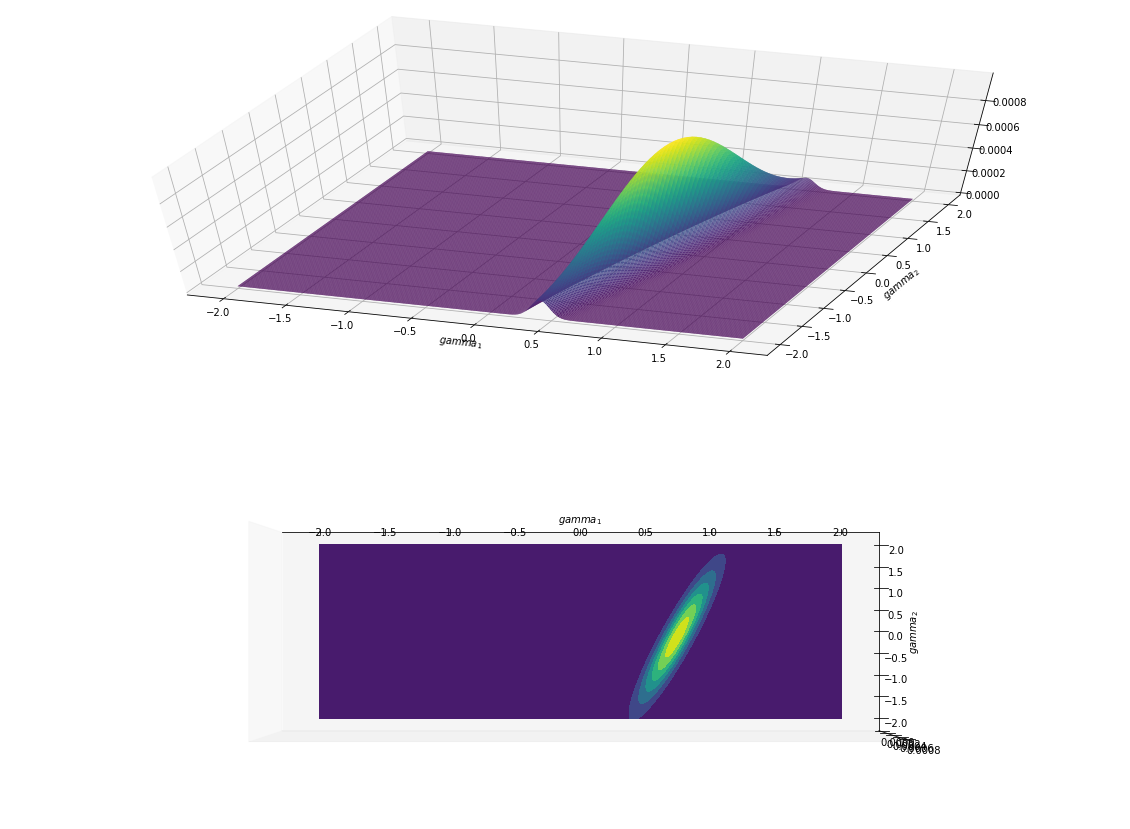

In [162]:
Mu = mu_vects[0]
Sigma = cov_matrices[0]
plot_gaussian(Mu, Sigma)

50 adatpont esetén:

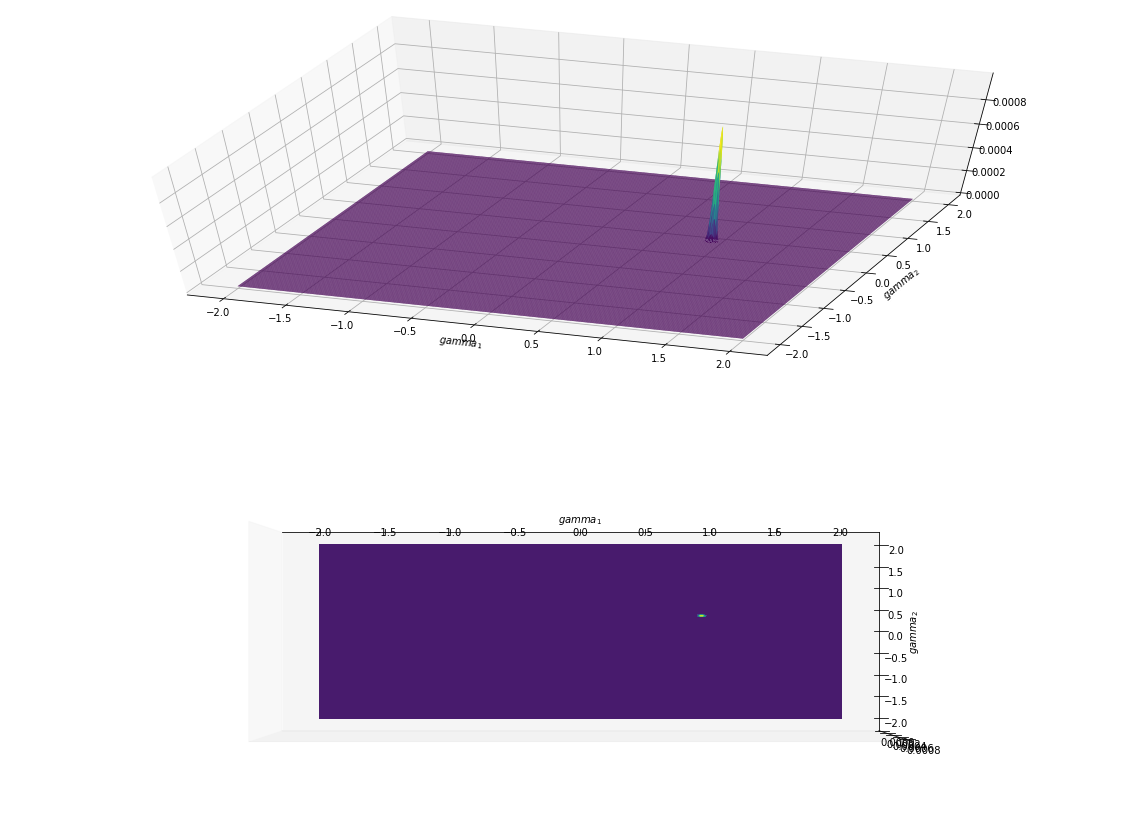

In [163]:
Mu = mu_vects[1]
Sigma = cov_matrices[1]
plot_gaussian(Mu, Sigma)

100 adatpont esetén:

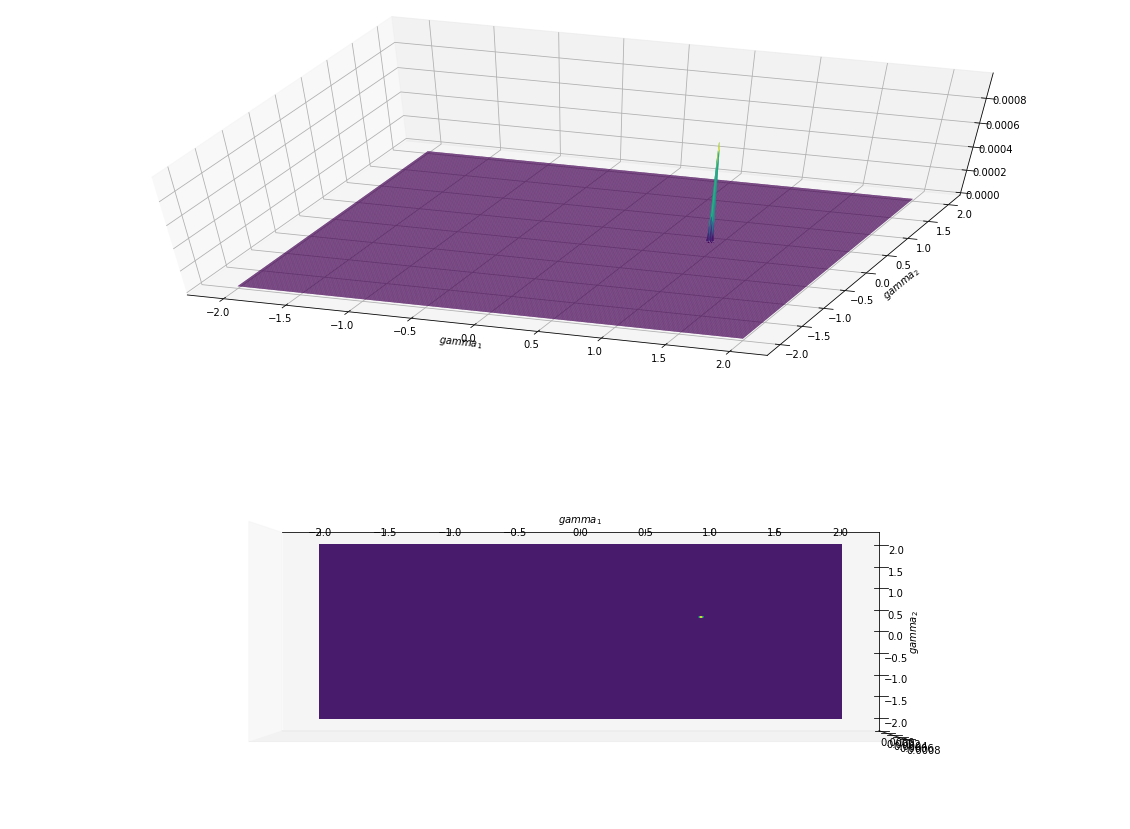

In [164]:
Mu = mu_vects[2]
Sigma = cov_matrices[2
plot_gaussian(Mu, Sigma)

1000 adatpont esetén:

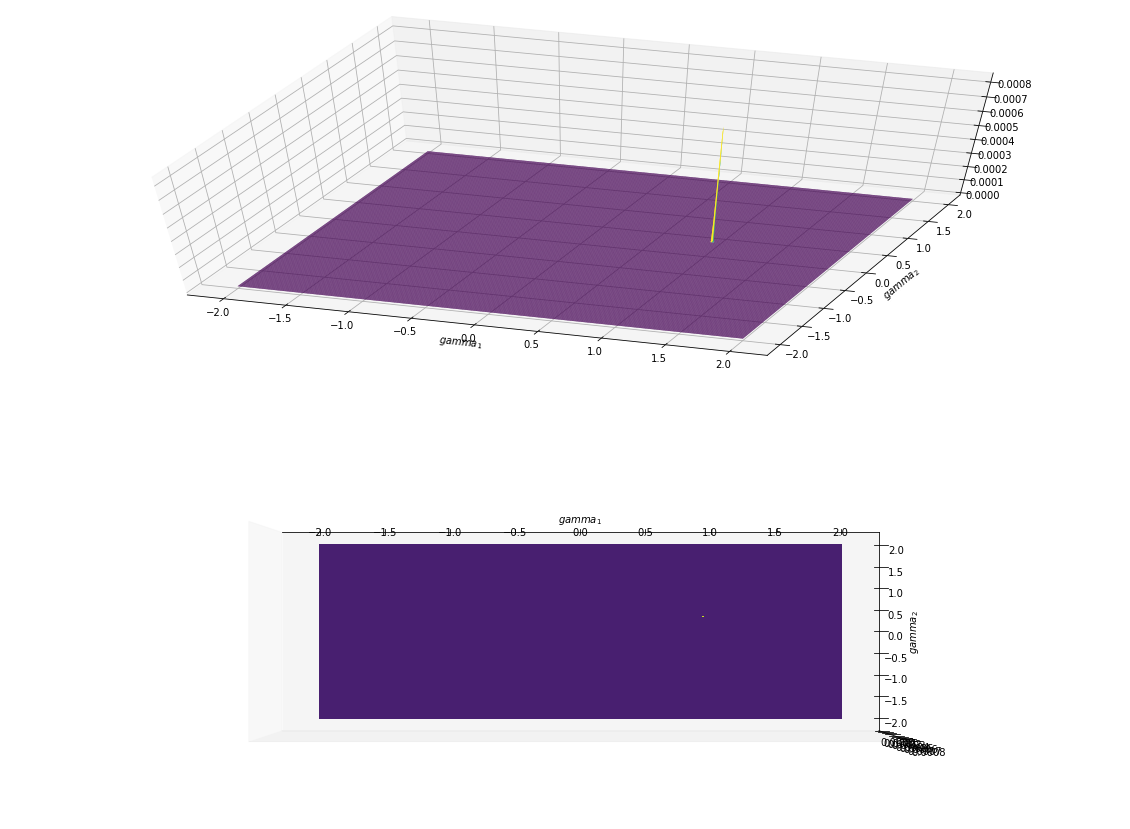

In [165]:
Mu = mu_vects[-1]
Sigma = cov_matrices[-1]
plot_gaussian(Mu, Sigma)